<a href="https://colab.research.google.com/github/chriswhong/311getter/blob/master/geopandas_small_multiples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install geopandas

     |████████████████████████████████| 921kB 9.3MB/s 
     |████████████████████████████████| 10.1MB 29.1MB/s 
     |████████████████████████████████| 11.8MB 200kB/s 


In [0]:
# Based on medium.com tutorial: https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d

import pandas as pd
import geopandas as gpd
import requests
import zipfile
import io
import matplotlib.pyplot as plt


In [9]:
#technique for downloading and unzipping shapefiles from this example: https://medium.com/@loldja/reading-shapefile-zips-from-a-url-in-python-3-93ea8d727856
url = 'https://data.cityofnewyork.us/api/geospatial/yfnk-k7r4?method=export&format=Original'
local_path = 'tmp/'
print('Downloading shapefile...')
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

Done
['nycd_19b/nycd.dbf', 'nycd_19b/nycd.prj', 'nycd_19b/nycd.shp', 'nycd_19b/nycd.shx']


In [71]:
map_df = gpd.read_file('tmp/nycd_19b/nycd.shp')
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df


,BoroCD,Shape_Leng,Shape_Area,geometry
0,311,51549.557899,1.031778e+08,"POLYGON ((991748.394 161084.955, 991860.956 16..."
1,313,65821.875617,8.819569e+07,"POLYGON ((988770.762 156350.512, 988958.229 15..."
2,312,52245.830495,9.952550e+07,"POLYGON ((992187.408 175455.468, 992239.079 17..."
3,304,37008.100320,5.666322e+07,"POLYGON ((1012965.523 187886.949, 1012949.003 ..."
4,212,83998.355508,1.548966e+08,"POLYGON ((1041252.473 261280.034, 1041167.230 ..."
...,...,...,...,...
66,227,28391.629705,3.143201e+07,"POLYGON ((1020056.125 256149.857, 1020056.849 ..."
67,401,90042.718108,1.715489e+08,"MULTIPOLYGON (((1010148.119 227175.052, 101124..."
68,402,71543.044665,1.398915e+08,"POLYGON ((1012530.819 214083.134, 1012518.675 ..."
69,502,142669.724480,5.931981e+08,"MULTIPOLYGON (((963842.054 150006.498, 963845...."


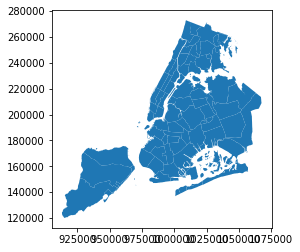

In [11]:
map_df.plot()

In [31]:
# get 311 data from my downloader tool

#https://cwhong.cartodb.com/api/v2/sql?skipfields=cartodb_id,created_at,updated_at,name,description&format=csv&filename=311&q=SELECT%20*%20FROM%20cleaned%20a%20WHERE%20ST_INTERSECTS(ST_MakeEnvelope(-74.04853820800781,40.65733169577193,-73.88477325439453,40.76143090333971,4326),%20a.the_geom)%20AND%20created_date%20%3E=%20%272019-10-23%27%20AND%20created_date%20%3C=%20%272019-11-23%27
last_week_311 = pd.read_csv("https://cwhong.cartodb.com/api/v2/sql?skipfields=cartodb_id,created_at,updated_at,name,description&format=csv&filename=311&q=SELECT%20*%20FROM%20cleaned%20a%20WHERE%20ST_INTERSECTS(ST_MakeEnvelope(-74.70291137695312,40.30152342981563,-73.39279174804688,41.13419316582356,4326),%20a.the_geom)%20AND%20created_date%20%3E=%20%272019-10-23%27%20AND%20created_date%20%3C=%20%272019-11-23%27")

last_week_311.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,the_geom,location_zip,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,cross_street_2,intersection_street_1,intersection_street_2,address_type,city,landmark,facility_type,status,due_date,the_geom_webmercator,resolution_action_updated_date,community_board,bbl,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location,location_address,location_city,location_state,resolution_description
0,0101000020E6100000D83697BA5D7D52C00E9437E6D156...,NaN,44989964,2019-11-21 19:03:00+00,NaN,DOT,Department of Transportation,Traffic Signal Condition,Pedestrian Signal,NaN,11238,NaN,NaN,NaN,NaN,CLASSON AVENUE,DEAN STREET,INTERSECTION,BROOKLYN,NaN,NaN,Open,NaN,0101000020110F000092C0264319685FC1CECB56D4A2F0...,NaN,08 BROOKLYN,NaN,BROOKLYN,995665,186395,UNKNOWN,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.678281,-73.958846,POINT (-73.95884575621619 40.6782806178454),NaN,NaN,NaN,NaN
1,0101000020E6100000D26B5A40697A52C0079ABDE1B656...,NaN,44982163,2019-11-21 18:51:00+00,2019-11-22 17:00:00+00,DSNY,BCC - Brooklyn North,Derelict Vehicles,14 Derelict Vehicles,Street,11233,2 MARCONI PLACE,MARCONI PLACE,HERKIMER STREET,ATLANTIC AVENUE,NaN,NaN,ADDRESS,BROOKLYN,NaN,DSNY Garage,Closed,NaN,0101000020110F00002AC1254F14635FC118E7B99284F0...,2019-11-22 18:19:00+00,16 BROOKLYN,3.015650e+09,BROOKLYN,1008472,186104,ONLINE,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.677456,-73.912674,POINT (-73.91267403440659 40.677456109599056),NaN,NaN,NaN,NaN
2,0101000020E610000025BAACED547152C009BE57270B5A...,NaN,44996377,2019-11-22 23:44:00+00,NaN,DEP,Department of Environmental Protection,Sewer,Sewer Backup (Use Comments) (SA),NaN,11412,185-20 DUNLOP AVENUE,DUNLOP AVENUE,HANNIBAL ST,LIBERTY AVE,NaN,NaN,ADDRESS,Saint Albans,NaN,NaN,Open,NaN,0101000020110F0000FC167536A8535FC12D5AC5313FF4...,NaN,12 QUEENS,4.103500e+09,QUEENS,1047797,195651,PHONE,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.703465,-73.770809,POINT (-73.77080861919292 40.70346538337987),NaN,NaN,NaN,NaN
3,0101000020E61000004C83F61D978052C0A3D3E1558F5E...,NaN,44992906,2019-11-22 23:35:00+00,NaN,DEP,Department of Environmental Protection,Noise,Noise: Construction Equipment (NC1),NaN,10014,113 HORATIO STREET,HORATIO STREET,WASHINGTON ST,WEST ST,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Open,NaN,0101000020110F000088DD6544936D5FC11A9E78D14EF9...,NaN,02 MANHATTAN,1.006430e+09,MANHATTAN,981694,208423,PHONE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.738749,-74.009223,POINT (-74.00922345231555 40.73874925162024),NaN,NaN,NaN,NaN
4,0101000020E61000006C1A7EAA2C8052C0FD4537796D4D...,NaN,44994487,2019-11-22 23:20:00+00,NaN,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,11214,85 BAY 20 STREET,BAY 20 STREET,86 ST,BENSON AVE,NaN,NaN,ADDRESS,BROOKLYN,NaN,NaN,Open,NaN,0101000020110F0000C4820873DE6C5FC16B2BD9A01FE6...,NaN,11 BROOKLYN,3.063710e+09,BROOKLYN,983493,159659,ONLINE,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.604903,-74.002726,POINT (-74.00272619547621 40.60490336607834),NaN,NaN,NaN,NaN


In [32]:
# get rid of unnecessary columns, all we need is community district and complaint type

last_week_311_trimmed = last_week_311[['community_board', 'complaint_type']]
last_week_311_trimmed.head()

#53,482 311 complaints in this period

,community_board,complaint_type
0,08 BROOKLYN,Traffic Signal Condition
1,16 BROOKLYN,Derelict Vehicles
2,12 QUEENS,Sewer
3,02 MANHATTAN,Noise
4,11 BROOKLYN,Noise


In [0]:
# filter for only rows whose community board starts with two digits
# this uses a regular expression to check the string for a match
last_week_311_trimmed = last_week_311_trimmed[last_week_311_trimmed.community_board.str.contains('^\d{2}\s', regex= True, na=False)]

In [58]:
# we want to transform this to get a count for each complaint type

pivoted = last_week_311_trimmed.pivot_table(index='community_board', columns='complaint_type', aggfunc=len)
pivoted = pivoted.reset_index()
pivoted

complaint_type,community_board,APPLIANCE,Abandoned Vehicle,Air Quality,Animal Facility - No Permit,Animal in a Park,Animal-Abuse,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,Bike/Roller/Skate Chronic,Blocked Driveway,Boilers,Bridge Condition,Broken Parking Meter,Building Condition,Building Marshals office,Building/Use,Bus Stop Shelter Complaint,Bus Stop Shelter Placement,Consumer Complaint,Cooling Tower,Cranes and Derricks,Curb Condition,DEP Sidewalk Condition,DEP Street Condition,DOOR/WINDOW,Damaged Tree,Day Care,Dead/Dying Tree,Dept of Investigations,Derelict Bicycle,Derelict Vehicles,Dirty Conditions,Disorderly Youth,Drinking,Drinking Water,Drug Activity,ELECTRIC,...,Rodent,Root/Sewer/Sidewalk Condition,SAFETY,Sanitation Condition,Scaffold Safety,School Maintenance,Sewer,Sidewalk Condition,Single Occupancy Bathroom,Smoking,Snow,Special Natural Area District (SNAD),Special Projects Inspection Team (SPIT),Squeegee,Standing Water,Street Condition,Street Light Condition,Street Sign - Damaged,Street Sign - Dangling,Street Sign - Missing,Tattooing,Taxi Complaint,Taxi Compliment,Taxi Report,Traffic,Traffic Signal Condition,UNSANITARY CONDITION,Unleashed Dog,Unsanitary Animal Facility,Unsanitary Animal Pvt Property,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,WATER LEAK,Water Conservation,Water Quality,Water System,Window Guard
0,01 BRONX,19.0,30.0,3.0,NaN,1.0,12.0,3.0,NaN,NaN,NaN,1.0,94.0,3.0,NaN,11.0,NaN,NaN,4.0,NaN,1.0,22.0,NaN,NaN,4.0,NaN,NaN,21.0,4.0,4.0,3.0,NaN,1.0,26.0,10.0,NaN,2.0,NaN,1.0,9.0,...,24.0,1.0,4.0,8.0,NaN,5.0,11.0,21.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,34.0,14.0,4.0,1.0,3.0,NaN,5.0,NaN,NaN,1.0,11.0,67.0,NaN,NaN,2.0,NaN,NaN,NaN,3.0,1.0,43.0,NaN,1.0,49.0,NaN
1,01 BROOKLYN,15.0,61.0,33.0,NaN,7.0,19.0,2.0,2.0,NaN,2.0,2.0,273.0,1.0,NaN,21.0,NaN,NaN,22.0,1.0,NaN,21.0,NaN,1.0,19.0,NaN,NaN,24.0,39.0,NaN,7.0,NaN,23.0,43.0,58.0,NaN,5.0,NaN,7.0,15.0,...,84.0,14.0,3.0,9.0,1.0,4.0,34.0,161.0,NaN,2.0,NaN,NaN,13.0,NaN,NaN,136.0,67.0,17.0,4.0,3.0,1.0,14.0,NaN,1.0,16.0,70.0,61.0,NaN,1.0,NaN,NaN,1.0,NaN,5.0,2.0,17.0,1.0,2.0,58.0,NaN
2,01 MANHATTAN,NaN,7.0,9.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,4.0,16.0,1.0,NaN,17.0,NaN,NaN,1.0,NaN,NaN,14.0,NaN,NaN,9.0,NaN,NaN,3.0,1.0,NaN,NaN,NaN,1.0,2.0,14.0,NaN,NaN,NaN,3.0,NaN,...,15.0,NaN,1.0,5.0,NaN,NaN,7.0,64.0,2.0,3.0,NaN,NaN,13.0,1.0,NaN,41.0,29.0,9.0,9.0,2.0,NaN,30.0,1.0,3.0,5.0,43.0,8.0,3.0,NaN,1.0,NaN,1.0,NaN,74.0,9.0,NaN,2.0,1.0,23.0,NaN
3,01 QUEENS,7.0,82.0,16.0,NaN,NaN,15.0,1.0,NaN,NaN,NaN,1.0,472.0,2.0,NaN,45.0,NaN,NaN,43.0,7.0,1.0,35.0,NaN,NaN,9.0,NaN,NaN,17.0,54.0,1.0,14.0,NaN,2.0,59.0,25.0,NaN,3.0,1.0,3.0,16.0,...,33.0,8.0,11.0,3.0,1.0,1.0,38.0,63.0,1.0,6.0,NaN,NaN,8.0,NaN,NaN,148.0,75.0,15.0,4.0,15.0,2.0,13.0,NaN,1.0,12.0,69.0,51.0,2.0,NaN,4.0,1.0,1.0,NaN,3.0,5.0,27.0,1.0,4.0,82.0,NaN
4,01 STATEN ISLAND,16.0,140.0,16.0,NaN,1.0,18.0,4.0,NaN,NaN,NaN,NaN,178.0,3.0,NaN,17.0,NaN,NaN,38.0,4.0,1.0,25.0,NaN,1.0,15.0,NaN,NaN,14.0,61.0,NaN,17.0,NaN,NaN,59.0,46.0,NaN,1.0,NaN,11.0,25.0,...,53.0,47.0,8.0,4.0,NaN,NaN,84.0,69.0,NaN,4.0,1.0,1.0,1.0,NaN,1.0,167.0,147.0,8.0,12.0,10.0,NaN,3.0,NaN,NaN,4.0,103.0,59.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,21.0,13.0,4.0,250.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,81 QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
67,82 QUEENS,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1

In [82]:
# convert community_board value to community district

def func(row):
    if 'MANHATTAN' in row['community_board']:
        return '1'
    elif 'BRONX' in row['community_board']:
      return '2' 
    elif 'BROOKLYN' in row['community_board']:
      return '3' 
    elif 'QUEENS' in row['community_board']:
      return '4' 
    elif 'STATEN ISLAND' in row['community_board']:
      return '5' 
    else:
        return 'other'

pivoted['boro'] = pivoted.apply(func, axis=1)

# cd will be first 2 characters of community board
pivoted['cd'] = pivoted['community_board'].str[:2]

pivoted['borocd'] = pd.to_numeric(pivoted['boro'] + pivoted['cd'])



complaint_type,community_board,APPLIANCE,Abandoned Vehicle,Air Quality,Animal Facility - No Permit,Animal in a Park,Animal-Abuse,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,Bike/Roller/Skate Chronic,Blocked Driveway,Boilers,Bridge Condition,Broken Parking Meter,Building Condition,Building Marshals office,Building/Use,Bus Stop Shelter Complaint,Bus Stop Shelter Placement,Consumer Complaint,Cooling Tower,Cranes and Derricks,Curb Condition,DEP Sidewalk Condition,DEP Street Condition,DOOR/WINDOW,Damaged Tree,Day Care,Dead/Dying Tree,Dept of Investigations,Derelict Bicycle,Derelict Vehicles,Dirty Conditions,Disorderly Youth,Drinking,Drinking Water,Drug Activity,ELECTRIC,...,SAFETY,Sanitation Condition,Scaffold Safety,School Maintenance,Sewer,Sidewalk Condition,Single Occupancy Bathroom,Smoking,Snow,Special Natural Area District (SNAD),Special Projects Inspection Team (SPIT),Squeegee,Standing Water,Street Condition,Street Light Condition,Street Sign - Damaged,Street Sign - Dangling,Street Sign - Missing,Tattooing,Taxi Complaint,Taxi Compliment,Taxi Report,Traffic,Traffic Signal Condition,UNSANITARY CONDITION,Unleashed Dog,Unsanitary Animal Facility,Unsanitary Animal Pvt Property,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,WATER LEAK,Water Conservation,Water Quality,Water System,Window Guard,boro,cd
borocd,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
201,01 BRONX,19.0,30.0,3.0,NaN,1.0,12.0,3.0,NaN,NaN,NaN,1.0,94.0,3.0,NaN,11.0,NaN,NaN,4.0,NaN,1.0,22.0,NaN,NaN,4.0,NaN,NaN,21.0,4.0,4.0,3.0,NaN,1.0,26.0,10.0,NaN,2.0,NaN,1.0,9.0,...,4.0,8.0,NaN,5.0,11.0,21.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,34.0,14.0,4.0,1.0,3.0,NaN,5.0,NaN,NaN,1.0,11.0,67.0,NaN,NaN,2.0,NaN,NaN,NaN,3.0,1.0,43.0,NaN,1.0,49.0,NaN,2,01
301,01 BROOKLYN,15.0,61.0,33.0,NaN,7.0,19.0,2.0,2.0,NaN,2.0,2.0,273.0,1.0,NaN,21.0,NaN,NaN,22.0,1.0,NaN,21.0,NaN,1.0,19.0,NaN,NaN,24.0,39.0,NaN,7.0,NaN,23.0,43.0,58.0,NaN,5.0,NaN,7.0,15.0,...,3.0,9.0,1.0,4.0,34.0,161.0,NaN,2.0,NaN,NaN,13.0,NaN,NaN,136.0,67.0,17.0,4.0,3.0,1.0,14.0,NaN,1.0,16.0,70.0,61.0,NaN,1.0,NaN,NaN,1.0,NaN,5.0,2.0,17.0,1.0,2.0,58.0,NaN,3,01
101,01 MANHATTAN,NaN,7.0,9.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,4.0,16.0,1.0,NaN,17.0,NaN,NaN,1.0,NaN,NaN,14.0,NaN,NaN,9.0,NaN,NaN,3.0,1.0,NaN,NaN,NaN,1.0,2.0,14.0,NaN,NaN,NaN,3.0,NaN,...,1.0,5.0,NaN,NaN,7.0,64.0,2.0,3.0,NaN,NaN,13.0,1.0,NaN,41.0,29.0,9.0,9.0,2.0,NaN,30.0,1.0,3.0,5.0,43.0,8.0,3.0,NaN,1.0,NaN,1.0,NaN,74.0,9.0,NaN,2.0,1.0,23.0,NaN,1,01
401,01 QUEENS,7.0,82.0,16.0,NaN,NaN,15.0,1.0,NaN,NaN,NaN,1.0,472.0,2.0,NaN,45.0,NaN,NaN,43.0,7.0,1.0,35.0,NaN,NaN,9.0,NaN,NaN,17.0,54.0,1.0,14.0,NaN,2.0,59.0,25.0,NaN,3.0,1.0,3.0,16.0,...,11.0,3.0,1.0,1.0,38.0,63.0,1.0,6.0,NaN,NaN,8.0,NaN,NaN,148.0,75.0,15.0,4.0,15.0,2.0,13.0,NaN,1.0,12.0,69.0,51.0,2.0,NaN,4.0,1.0,1.0,NaN,3.0,5.0,27.0,1.0,4.0,82.0,NaN,4,01
501,01 STATEN ISLAND,16.0,140.0,16.0,NaN,1.0,18.0,4.0,NaN,NaN,NaN,NaN,178.0,3.0,NaN,17.0,NaN,NaN,38.0,4.0,1.0,25.0,NaN,1.0,15.0,NaN,NaN,14.0,61.0,NaN,17.0,NaN,NaN,59.0,46.0,NaN,1.0,NaN,11.0,25.0,...,8.0,4.0,NaN,NaN,84.0,69.0,NaN,4.0,1.0,1.0,1.0,NaN,1.0,167.0,147.0,8.0,12.0,10.0,NaN,3.0,NaN,NaN,4.0,103.0,59.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,21.0,13.0,4.0,250.0,NaN,5,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,81 QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4,81
482,82 QUEENS,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [0]:
# sort by Abandoned Vehicle Count
pivoted.sor

In [83]:
# Join with polygons

merged = map_df.set_index('BoroCD').join(pivoted.set_index('borocd')).sort_values(by=['BoroCD'])
merged


,Shape_Leng,Shape_Area,geometry,community_board,APPLIANCE,Abandoned Vehicle,Air Quality,Animal Facility - No Permit,Animal in a Park,Animal-Abuse,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,Bike/Roller/Skate Chronic,Blocked Driveway,Boilers,Bridge Condition,Broken Parking Meter,Building Condition,Building Marshals office,Building/Use,Bus Stop Shelter Complaint,Bus Stop Shelter Placement,Consumer Complaint,Cooling Tower,Cranes and Derricks,Curb Condition,DEP Sidewalk Condition,DEP Street Condition,DOOR/WINDOW,Damaged Tree,Day Care,Dead/Dying Tree,Dept of Investigations,Derelict Bicycle,Derelict Vehicles,Dirty Conditions,Disorderly Youth,Drinking,...,SAFETY,Sanitation Condition,Scaffold Safety,School Maintenance,Sewer,Sidewalk Condition,Single Occupancy Bathroom,Smoking,Snow,Special Natural Area District (SNAD),Special Projects Inspection Team (SPIT),Squeegee,Standing Water,Street Condition,Street Light Condition,Street Sign - Damaged,Street Sign - Dangling,Street Sign - Missing,Tattooing,Taxi Complaint,Taxi Compliment,Taxi Report,Traffic,Traffic Signal Condition,UNSANITARY CONDITION,Unleashed Dog,Unsanitary Animal Facility,Unsanitary Animal Pvt Property,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,WATER LEAK,Water Conservation,Water Quality,Water System,Window Guard,boro,cd
BoroCD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
101,73762.393219,4.268659e+07,"MULTIPOLYGON (((972081.788 190733.467, 972184....",01 MANHATTAN,NaN,7.0,9.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,4.0,16.0,1.0,NaN,17.0,NaN,NaN,1.0,NaN,NaN,14.0,NaN,NaN,9.0,NaN,NaN,3.0,1.0,NaN,NaN,NaN,1.0,2.0,14.0,NaN,NaN,...,1.0,5.0,NaN,NaN,7.0,64.0,2.0,3.0,NaN,NaN,13.0,1.0,NaN,41.0,29.0,9.0,9.0,2.0,NaN,30.0,1.0,3.0,5.0,43.0,8.0,3.0,NaN,1.0,NaN,1.0,NaN,74.0,9.0,NaN,2.0,1.0,23.0,NaN,1,01
102,34130.595861,3.768921e+07,"POLYGON ((985125.733 207917.071, 986018.960 20...",02 MANHATTAN,3.0,1.0,20.0,NaN,2.0,13.0,5.0,1.0,2.0,1.0,7.0,7.0,8.0,NaN,74.0,NaN,NaN,2.0,NaN,NaN,14.0,NaN,1.0,5.0,NaN,NaN,18.0,13.0,NaN,NaN,NaN,12.0,2.0,25.0,2.0,4.0,...,2.0,NaN,1.0,5.0,23.0,43.0,NaN,3.0,NaN,NaN,17.0,NaN,NaN,77.0,54.0,3.0,6.0,4.0,NaN,45.0,NaN,6.0,17.0,25.0,34.0,NaN,NaN,NaN,NaN,2.0,NaN,24.0,5.0,9.0,1.0,3.0,108.0,NaN,1,02
103,30468.340600,4.687970e+07,"POLYGON ((987359.695 206680.171, 987802.827 20...",03 MANHATTAN,9.0,8.0,24.0,NaN,4.0,12.0,3.0,NaN,NaN,1.0,4.0,13.0,11.0,NaN,51.0,NaN,NaN,18.0,1.0,NaN,14.0,NaN,NaN,4.0,NaN,NaN,23.0,9.0,1.0,4.0,NaN,15.0,8.0,19.0,NaN,2.0,...,8.0,3.0,1.0,2.0,13.0,54.0,NaN,6.0,NaN,NaN,24.0,NaN,NaN,57.0,38.0,8.0,5.0,8.0,NaN,24.0,1.0,NaN,12.0,22.0,65.0,NaN,NaN,1.0,NaN,3.0,NaN,13.0,7.0,17.0,2.0,13.0,25.0,NaN,1,03
104,67623.946684,4.931179e+07,"POLYGON ((985929.324 220967.002, 985995.954 22...",04 MANHATTAN,8.0,5.0,42.0,NaN,1.0,9.0,2.0,2.0,1.0,NaN,5.0,28.0,13.0,NaN,49.0,NaN,NaN,3.0,2.0,NaN,22.0,NaN,NaN,4.0,NaN,NaN,17.0,8.0,NaN,2.0,NaN,6.0,2.0,25.0,NaN,NaN,...,2.0,1.0,2.0,3.0,18.0,39.0,NaN,3.0,NaN,NaN,23.0,NaN,1.0,97.0,NaN,7.0,4.0,5.0,NaN,88.0,NaN,6.0,12.0,NaN,46.0,NaN,NaN,1.0,NaN,NaN,NaN,3.0,2.0,18.0,1.0,4.0,67.0,NaN,1,04
105,35288.305200,4.379030e+07,"POLYGON ((991725.244 217725.299, 992169.505 21...",05 MANHATTAN,1.0,4.0,24.0,NaN,2.0,8.0,5.0,2.0,NaN,1.0,1.0,18.0,2.0,NaN,81.0,1.0,NaN,10.0,NaN,NaN,45.0,NaN,NaN,2.0,NaN,NaN,1.0,5.0,NaN,2.0,NaN,8.0,6.0,29.0,NaN,NaN,...,1.0,NaN,NaN,1.0,16.0,39.0,NaN,4.0,NaN,NaN,16.0,NaN,NaN,119.0,3.0,4.0,7.0,5.0,NaN,148.0,2.0,18.0,10.0,2.0,20.0,NaN,NaN,NaN,2.0,1.0,NaN,53.0,7.0,5.0,3.0,NaN,73.0,NaN,1,05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,247815.353417,1.237801e+08,"MULTIPOLYGON (((1003211.277 142534.469, 100337...",84 QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


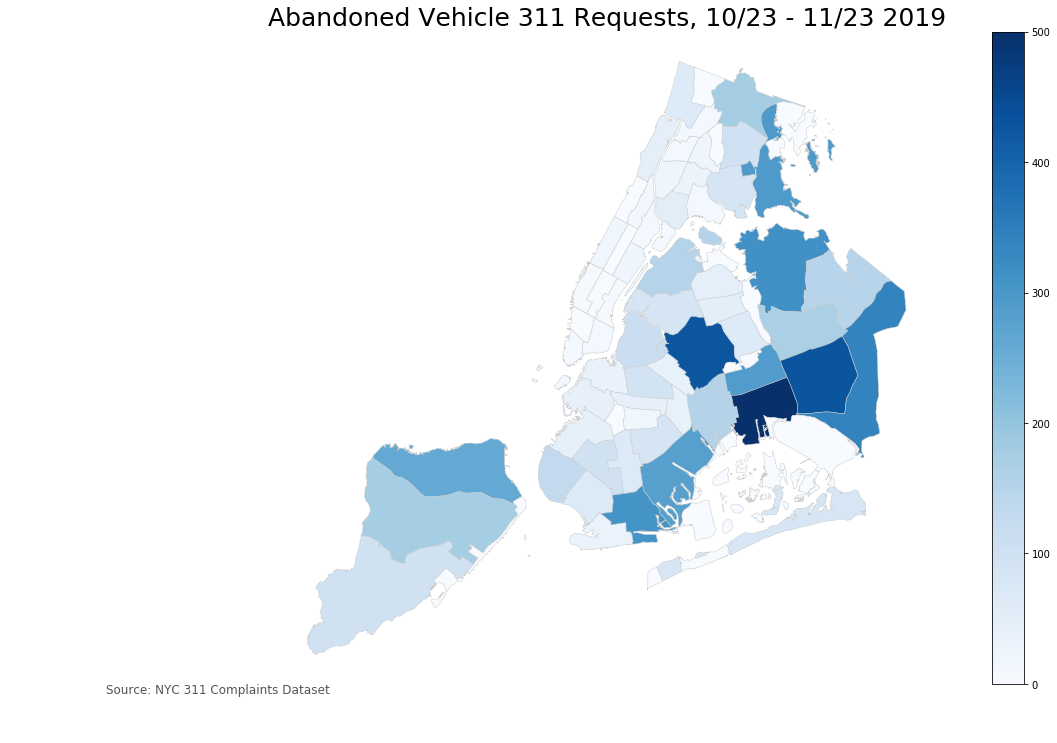

In [99]:
# make a map

# set a variable that will call whatever column we want to visualise on the map
variable = 'Abandoned Vehicle'
# set the range for the choropleth
vmin, vmax = 0, 500
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 12))

merged.plot(column=variable, cmap='Blues', linewidth=0.5, ax=ax, edgecolor='0.8')

ax.axis('off')

# add a title
ax.set_title('Abandoned Vehicle 311 Requests, 10/23 - 11/23 2019', fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: NYC 311 Complaints Dataset', xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

